In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt

tf.initialize(tf.cpu, "/O2 /fp:fast /openmp")

N = 512 
M = 512

def Boundary(i, j):
    N1, M1 = i.shape
    return 1.0 - tf.float((i < 3) | (i > N1-4) | (j < 3) | (j > M1-4))

def Jacobi(pressure, div, iterations):
    i, j = pressure.indices

    edge = Boundary(i, j)

    # pressure solve
    for it in range(iterations):
        pressure = edge * (pressure[i-1, j] + pressure[i+1, j] + pressure[i, j-1] + pressure[i, j+1] - div) / 4.0

    return pressure

# red-black Gauss-Seidel
def RBGS(pressure, div, iterations, overrelax=1.0):
    N1, M1 = pressure.shape
    i0, j0 = tf.indices([N1, M1/2])
    
    # pressure solve
    for it in range(iterations):
        new_pressure = tf.buffer([N1, M1], tf.float32)
        # red
        i, j = i0, 2*j0 + (i0 % 2)
        new_pressure[i,j] = pressure[i, j] * (1.0 - overrelax) + overrelax * (pressure[i-1, j] + pressure[i+1, j] + pressure[i, j-1] + pressure[i, j+1] - div[i, j]) / 4.0

        # black
        i, j = i0, 2*j0 + ((i0+1) % 2)
        new_pressure[i,j] = pressure[i, j] * (1.0 - overrelax) + overrelax * (new_pressure[i-1, j] + new_pressure[i+1, j] + new_pressure[i, j-1] + new_pressure[i, j+1] - div[i, j]) / 4.0
        pressure = new_pressure

    return pressure

def Restrict(field):
    N1, M1 = field.shape
    N2, M2 = N1/2, M1/2
    i, j = tf.indices([N2, M2])
    i, j = 2*i, 2*j
    return 0.25*(field[i, j] + field[i+1, j] + field[i, j+1] + field[i+1, j+1])

def Prolong(field, orig):
    i, j = orig.indices
    i, j = i/2, j/2
    return orig + field[i, j]

def Residual(pressure, div):
    i, j = pressure.indices
    return div - (pressure[i-1, j] + pressure[i+1, j] + pressure[i, j-1] + pressure[i, j+1] - 4.0*pressure)

def VCycle(pressure, div):
    pressure = RBGS(pressure, div, 1, overrelax=1.5)

    res = Residual(pressure, div)
    res = Restrict(res)
    pressure0 = RBGS(tf.zeros(res.shape), 4.0*res, 2, overrelax=1.5)

    res1 = Residual(pressure0, 4.0*res)
    res1 = Restrict(res1)
    pressure1 = RBGS(tf.zeros(res1.shape), 4.0*res1, 8, overrelax=1.5)
    pressure1 = RBGS(pressure1, 4.0*res1, 8)
    pressure0 = Prolong(pressure1, pressure0)

    pressure0 = RBGS(pressure0, 4.0*res, 2)
    pressure = Prolong(pressure0, pressure)

    pressure = RBGS(pressure, div, 1)

    return pressure

def PoissonTest():
    pressure = tf.input([N, M], tf.float32)
    div = tf.input([N, M], tf.float32)

    initial_res = Residual(pressure, div)

    pressure = VCycle(pressure, div)

    final_res = Residual(pressure, div)

    return [pressure, initial_res, final_res]


poissonTest = tf.compile(PoissonTest)

TensorFrost module loaded!
TensorProgram:
  Kernel count: 53
  Intermediate buffers: 34
  Lines of generated code: 903
  IR size: 4244



Residue decay: 22.020134


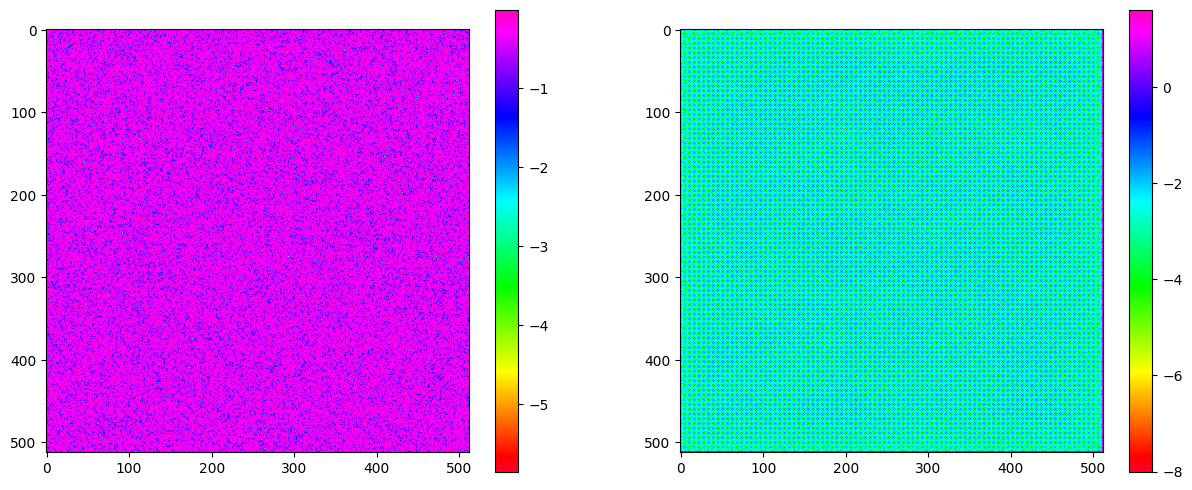

In [2]:
#create a random divergence field
div = np.random.rand(N, M).astype(np.float32)
div = tf.tensor(div)

#solve for the pressure
pressure = tf.tensor(np.zeros([N, M], np.float32))
pressure, ires, fres = poissonTest(pressure, div)

ires_numpy = ires.numpy
fres_numpy = fres.numpy
pressure_numpy = pressure.numpy

#compute the total residual
total_ires = np.sum(ires_numpy**2.0)
total_fres = np.sum(fres_numpy**2.0)
residue_decay = total_fres / total_ires

print("Residue decay: %f" % residue_decay)

#plot the residual and the pressure
plt.figure( figsize=(15, 6) )
plt.subplot(121)
plt.imshow(np.log10(np.abs(ires_numpy)+1e-8), cmap='gist_rainbow')
plt.colorbar()
plt.subplot(122)
plt.imshow(np.log10(np.abs(fres_numpy)+1e-8), cmap='gist_rainbow')
plt.colorbar()
plt.show()


